In [9]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary

# Load the data
data = pd.read_excel('energy_prices.xlsx')
print(data.head())

  Beschikbaar gesteld door jeroen.nl            Unnamed: 1
0                          datumtijd  Inkoop prijs per kWh
1                2013-01-01 01:00:00                0.0326
2                2013-01-01 02:00:00                0.0316
3                2013-01-01 03:00:00                0.0306
4                2013-01-01 04:00:00                0.0293


Index(['datumtijd', 'Inkoop prijs per kWh'], dtype='object')
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.58704D+00    |proj g|=  4.83391D+01


/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -3.62693D+00    |proj g|=  1.24950D-01

At iterate   10    f= -3.62696D+00    |proj g|=  3.45891D+00

At iterate   15    f= -3.64563D+00    |proj g|=  1.35573D+00

At iterate   20    f= -3.64574D+00    |proj g|=  1.50458D+00

At iterate   25    f= -3.64937D+00    |proj g|=  3.57210D+00

At iterate   30    f= -3.65103D+00    |proj g|=  1.32896D+00

At iterate   35    f= -3.66166D+00    |proj g|=  1.11677D+01

At iterate   40    f= -3.68954D+00    |proj g|=  1.40865D+01

At iterate   45    f= -3.69138D+00    |proj g|=  1.06201D+00

At iterate   50    f= -3.69178D+00    |proj g|=  1.95458D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prices: [0.03854673 0.05373495 0.05753184 0.0603003  0.05974609 0.06261143
 0.05930853 0.05679372 0.05349444 0.05144316 0.05011965 0.06165548
 0.07409455 0.06540385 0.05639674 0.05218406 0.05160714 0.04795513
 0.04603043 0.04159645 0.03681463 0.03592033 0.03474077 0.03495227]


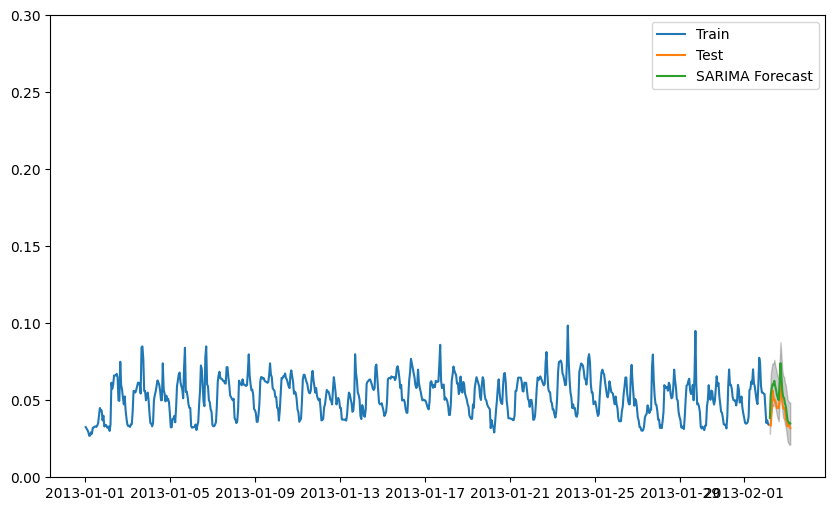

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/michall/anaconda3/envs/smart_charging/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/bf84a84b88a34d6eb71348576db37bfd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/bf84a84b88a34d6eb71348576db37bfd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1494 COLUMNS
At line 5309 RHS
At line 6799 BOUNDS
At line 7016 ENDATA
Problem MODEL has 1489 rows, 864 columns and 2950 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.01 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01

Status: Infeasible


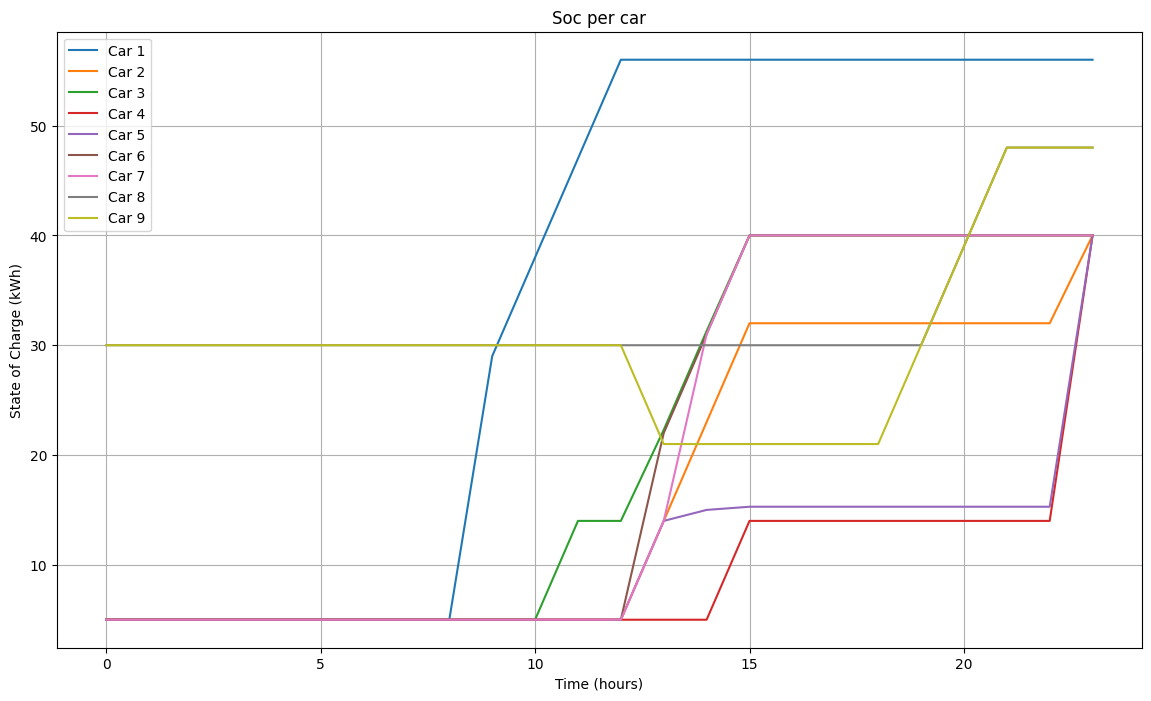

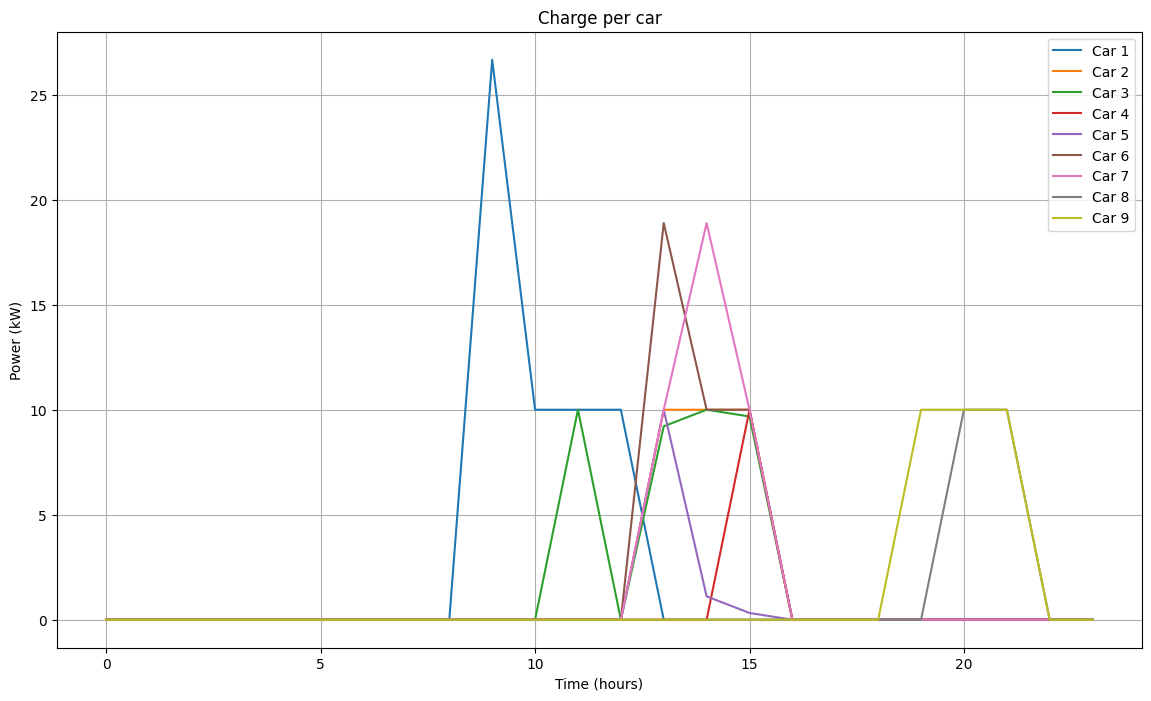

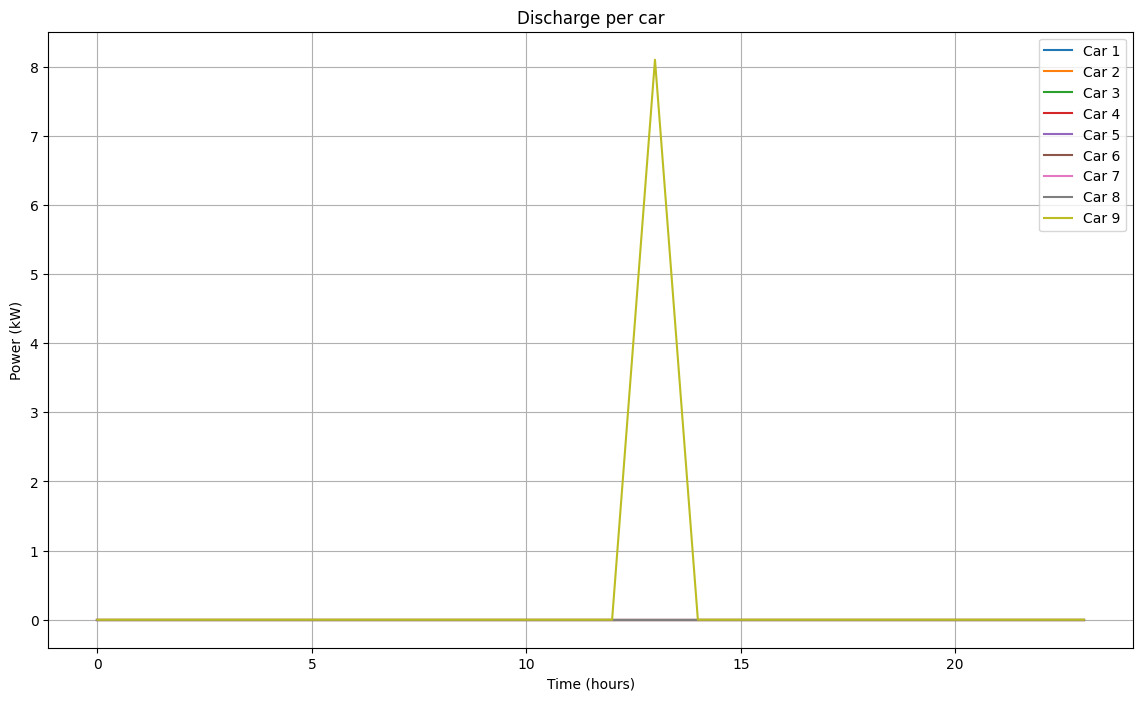

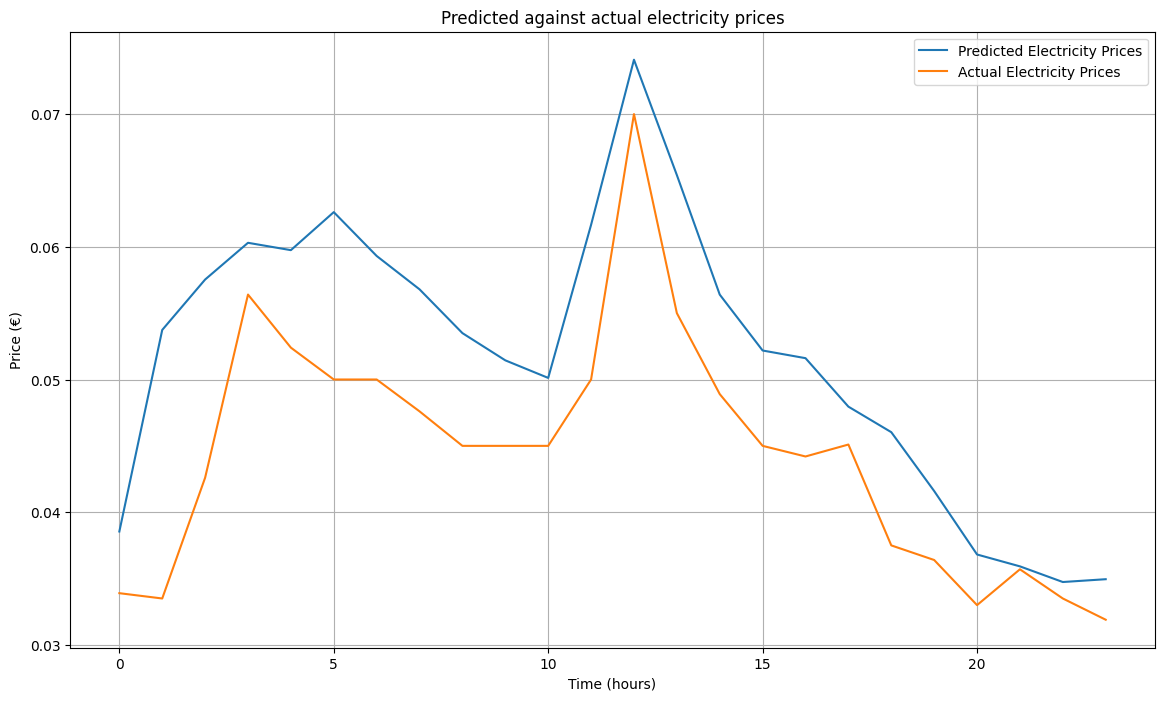

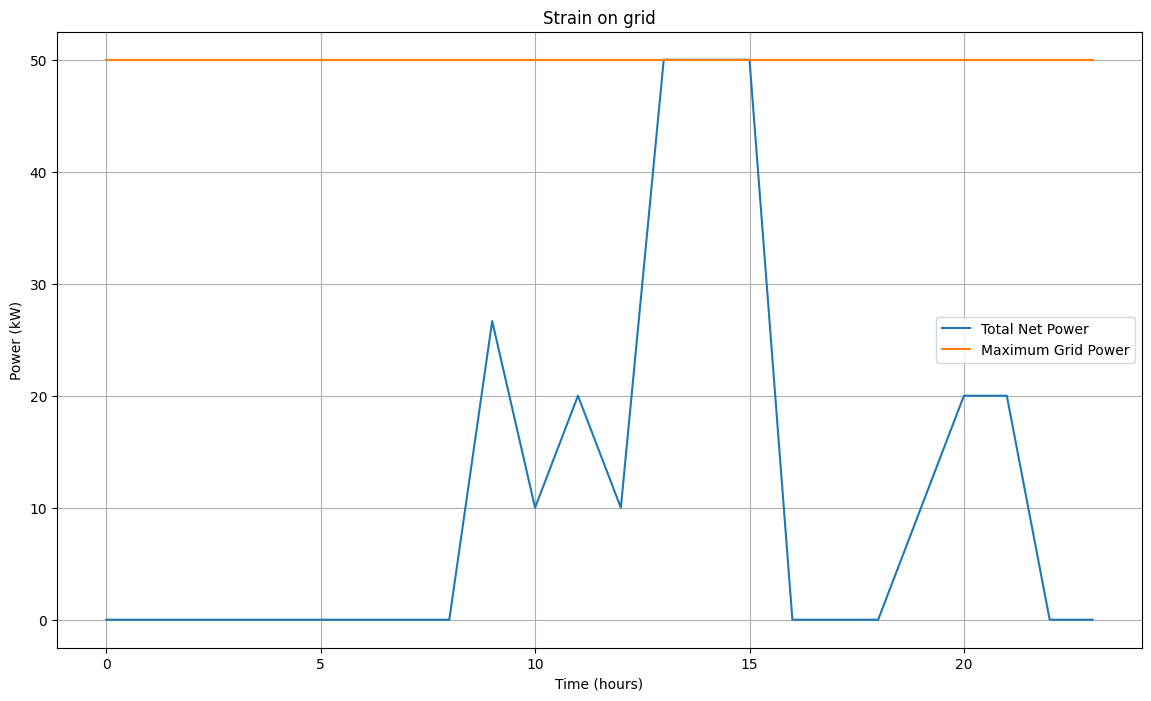

In [3]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pulp
import numpy as np

# Load data
data = pd.read_excel('energy_prices.xlsx', skiprows=1)

# Check the column names
print(data.columns)

# Rename columns if necessary (adjust to match your file's column names)
data.columns = ['datumtijd', 'Inkoop prijs per kWh']

# Ensure the datetime column is in the correct format
data['datumtijd'] = pd.to_datetime(data['datumtijd'])
data.set_index('datumtijd', inplace=True)

# Split data into training and test sets
train_data = data.iloc[0:772]
test_data = data.iloc[772:796]

# Fit SARIMA model (parameters can be tuned)
sarima_model = sm.tsa.statespace.SARIMAX(train_data['Inkoop prijs per kWh'],
                                         order=(0, 0, 2),
                                         seasonal_order=(1, 1, 1, 24)).fit()

# Forecast
sarima_forecast = sarima_model.get_forecast(steps=len(test_data))
forecast_ci = sarima_forecast.conf_int()
prices = sarima_forecast.predicted_mean.values
print(f'prices: {prices}')

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data['Inkoop prijs per kWh'], label='Train')
plt.plot(test_data['Inkoop prijs per kWh'], label='Test')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.ylim(0, 0.3)
plt.show()

model = pulp.LpProblem("EV_Charging", pulp.LpMinimize)
C = 9  # Number of cars
T = len(test_data)  # Number of time periods
eta_ch = 0.9  # Charging efficiency
eta_dis = 0.9  # Discharging efficiency
Pgrid_max = 50  # Maximum total charging power (kW)

# Hard-coded variants for charging speeds and battery capacities for each car
Pmax = [10]*C  # Max charging power is 10 kW for all cars
Dmax = [10]*C  # Max discharging power is 10 kW for all cars
Emax = [70] + [50]*6 + [60]*2  # Max battery capacity for each car

# Hard-coded arrival and departure times for each car
t_arrival = [9] + [13]*6 + [19]*2  # Arrival times for each car
t_departure = [12] + [15]*6 + [21]*2  # Departure times for each car

# Initial SoC for each car
E_initial = [5] + [5]*6 + [30]*2  # Initial SoC for each car

# Max charging per car
P = pulp.LpVariable.dicts("P", ((c, t) for c in range(C) for t in range(T)), lowBound=0, cat='Continuous')
# Max discharging per car
D = pulp.LpVariable.dicts("D", ((c, t) for c in range(C) for t in range(T)), lowBound=0, cat='Continuous')
# Car battery max value
E = pulp.LpVariable.dicts("E", ((c, t) for c in range(C) for t in range(T)), lowBound=0, cat='Continuous')
# Charging or not
u = pulp.LpVariable.dicts("u", ((c, t) for c in range(C) for t in range(T)), cat='Binary')

# Objective: Minimize total cost
model += pulp.lpSum(prices[t] * P[c, t] - prices[t] * D[c, t] for c in range(C) for t in range(T))

# Constraints
# Charging power limits
for c in range(C):
    for t in range(T):
        model += P[c, t] <= Pmax[c] * u[c, t]
        model += D[c, t] <= Dmax[c] * u[c, t]

# SoC limits
for c in range(C):
    for t in range(T):
        model += E[c, t] <= Emax[c]

# Initial SoC
for c in range(C):
    model += E[c, 0] == E_initial[c]

# SoC evolution with discharging
for c in range(C):
    for t in range(1, T):
        model += E[c, t] == E[c, t-1] + eta_ch * P[c, t] - (1 / eta_dis) * D[c, t]

# Ensure at least 80% SoC by the end of the time period
for c in range(C):
    model += E[c, T-1] >= Emax[c] * 0.8

# Non-negativity of SoC
for c in range(C):
    for t in range(T):
        model += E[c, t] >= 0

# Charging happens only within arrival and departure times
for c in range(C):
    for t in range(T):
        if t < t_arrival[c] or t > t_departure[c]:
            model += P[c, t] == 0
            model += D[c, t] == 0

# Total power limit constraint
for t in range(T):
    model += pulp.lpSum(P[c, t] - D[c, t] for c in range(C)) <= Pgrid_max

# Solve the problem
model.solve()

# Check the status of the solution
print(f"Status: {pulp.LpStatus[model.status]}")

# Extract results and plot
charging_power = np.zeros((C, T))
discharging_power = np.zeros((C, T))
soc = np.zeros((C, T))

for c in range(C):
    for t in range(T):
        charging_power[c, t] = pulp.value(P[c, t])
        discharging_power[c, t] = pulp.value(D[c, t])
        soc[c, t] = pulp.value(E[c, t])

# Plot the State of Charge (SoC) for each car
plt.figure(figsize=(14, 8))
plt.title('Soc per car')
for c in range(C):
    plt.plot(soc[c, :], label=f'Car {c+1}')
plt.xlabel('Time (hours)')
plt.ylabel('State of Charge (kWh)')
plt.legend()
plt.grid()
plt.show()

# Plot the charging power for each car
plt.figure(figsize=(14, 8))
plt.title('Charge per car')
for c in range(C):
    plt.plot(charging_power[c, :], label=f'Car {c+1}')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid()
plt.show()

# Plot the discharging power for each car
plt.figure(figsize=(14, 8))
plt.title('Discharge per car')
for c in range(C):
    plt.plot(discharging_power[c, :], label=f'Car {c+1}')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid()
plt.show()

# Plot the predicted and actual electricity prices
plt.figure(figsize=(14, 8))
plt.title('Predicted against actual electricity prices')
plt.plot(prices, label='Predicted Electricity Prices')
plt.plot(test_data['Inkoop prijs per kWh'].values, label='Actual Electricity Prices')
plt.xlabel('Time (hours)')
plt.ylabel('Price (€)')
plt.legend()
plt.grid()
plt.show()

# Plot the total charging power and strain on the EV grid
plt.figure(figsize=(14, 8))
plt.title('Strain on grid')
plt.plot(charging_power.sum(axis=0) - discharging_power.sum(axis=0), label='Total Net Power')
plt.plot([Pgrid_max for _ in range(T)], label='Maximum Grid Power')
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid()
plt.show()
